## Parte I: Analisis exploratorio

Bautista Boeri - 110898

Enlace a este notebook:https://colab.research.google.com/drive/127U7qVMn2ATcf_S7PWHUkfJWQvCnP8hg?usp=sharing

Importamos y descargamos dependencias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sbn
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
!pip install regex
import regex
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
BASE_PATH = '/content/drive/MyDrive/tp3/'
from google.colab import drive
drive.mount('/content/drive')

tweets = pd.read_csv(BASE_PATH + 'train.csv')
test = pd.read_csv(BASE_PATH + 'test.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Rellenamos los Nans

In [ ]:
# Recargar los datos originales para empezar limpio
tweets_refactored = pd.read_csv(BASE_PATH + 'train.csv')
test_refactored = pd.read_csv(BASE_PATH + 'test.csv')

# Llenar NaNs
tweets_refactored['keyword'] = tweets_refactored['keyword'].fillna('sin_keyword')
tweets_refactored['location'] = tweets_refactored['location'].fillna('sin_locacion')

test_refactored['keyword'] = test_refactored['keyword'].fillna('sin_keyword')
test_refactored['location'] = test_refactored['location'].fillna('sin_locacion')

print("Datos cargados y NaNs rellenados")
print(f"Tweets shape: {tweets_refactored.shape}")
print(f"Test shape: {test_refactored.shape}")

Datos cargados y NaNs rellenados
Tweets shape: (7613, 5)
Test shape: (3263, 4)


Se hara un analisis de algunas caracteristicas que podrian contener los textos de los tweets. Se tienen en cuenta algunos detalles como el uso de emojis, # o otros simbolos para ver si el uso de estos afecta de forma real el target final

In [ ]:

def contiene_emoji_o_emoticon(texto):
    if pd.isna(texto):
        return 0
    texto_str = str(texto)

    # 1. Patrón para Emojis Unicode
    emoji_pattern = regex.compile(r'[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]', flags=regex.UNICODE)
    emoji_count = len(emoji_pattern.findall(texto_str))

    # 2. Patrón para Emoticones de Texto comunes (ej: triste, feliz, asombro)
    emoticon_patterns = [":(", ":-" , ":)", ":-)", ":-/", ":O", ";)"]
    emoticon_count = 0
    for pattern in emoticon_patterns:
        emoticon_count += texto_str.count(pattern)

    return emoji_count + emoticon_count

def contains_four_consecutive_symbols(texto):
  """
  Detecta si el texto tiene 4 o más símbolos consecutivos (!!! ???? etc.)
  Útil para detectar tweets con urgencia o emoción intensa.
  """
  import re
  if pd.isna(texto):
      return False
  pattern = r'[?()$%=|°!]{4,}'
  return bool(re.search(pattern, str(texto)))

In [ ]:
# ================================
# 1. CANTIDAD DE EMOJIS/EMOTICONES
# ================================
tweets_refactored['cantidad_emoji'] = tweets_refactored['text'].apply(contiene_emoji_o_emoticon) + \
                                       tweets_refactored['location'].apply(contiene_emoji_o_emoticon)

test_refactored['cantidad_emoji'] = test_refactored['text'].apply(contiene_emoji_o_emoticon) + \
                                     test_refactored['location'].apply(contiene_emoji_o_emoticon)

print("✅ Feature 'cantidad_emoji' creada")
print(f"Range: {tweets_refactored['cantidad_emoji'].min()} - {tweets_refactored['cantidad_emoji'].max()}")

✅ Feature 'cantidad_emoji' creada
Range: 0 - 2


Viendo el rango podemos ver que no tweets con mas de 2 tweets

In [ ]:
# =======================
# 2. CANTIDAD DE HASHTAGS
# =======================
tweets_refactored['cantidad_hashtags'] = tweets_refactored['text'].str.count('#')
test_refactored['cantidad_hashtags'] = test_refactored['text'].str.count('#')

print("✅ Feature 'cantidad_hashtags' creada")
print(f"Range: {tweets_refactored['cantidad_hashtags'].min()} - {tweets_refactored['cantidad_hashtags'].max()}")
print(f"Tweets con 3+ hashtags: {(tweets_refactored['cantidad_hashtags'] >= 3).sum()}")

✅ Feature 'cantidad_hashtags' creada
Range: 0 - 13
Tweets con 3+ hashtags: 392


Aca podemos ver que la cantidad de hashtags varia bastante hasta llegando a algun tweet con 13 hashtags

In [ ]:
# ======================
# 3. CANTIDAD DE ARROBAS
# ======================
tweets_refactored['cantidad_arrobas'] = tweets_refactored['text'].str.count('@')
test_refactored['cantidad_arrobas'] = test_refactored['text'].str.count('@')

print("✅ Feature 'cantidad_arrobas' creada")
print(f"Range: {tweets_refactored['cantidad_arrobas'].min()} - {tweets_refactored['cantidad_arrobas'].max()}")
print(f"Tweets con 2+ arrobas: {(tweets_refactored['cantidad_arrobas'] >= 2).sum()}")

✅ Feature 'cantidad_arrobas' creada
Range: 0 - 8
Tweets con 2+ arrobas: 486


Se utiliza Vader para analizar el sentimiento del tweet. En esta ocacion se dividio el comportamiento en 4 features:


*   Muy negativo entre -1 y -0.5
*   Negativo entre -0.5 y 0
*   Positivo entre 0 y 0.5
*   Muy positivo entre 0.5 y 1





In [ ]:
# ==========================
# 4. ANÁLISIS DE SENTIMIENTO
# ==========================

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_category(compound_score):
    if compound_score < -0.5:
        return 'muy negativo'
    elif -0.5 <= compound_score < 0:
        return 'negativo'
    elif 0 <= compound_score < 0.5:
        return 'positivo'
    else:
        return 'muy positivo'

# Para TRAIN
tweets_refactored['compound'] = tweets_refactored['text'].apply(
    lambda tweet_text: analyzer.polarity_scores(tweet_text)['compound']
)
tweets_refactored['sentimiento'] = tweets_refactored['compound'].apply(get_sentiment_category)
tweets_refactored = tweets_refactored.drop(columns=['compound'])

# Para TEST
test_refactored['compound'] = test_refactored['text'].apply(
    lambda tweet_text: analyzer.polarity_scores(tweet_text)['compound']
)
test_refactored['sentimiento'] = test_refactored['compound'].apply(get_sentiment_category)
test_refactored = test_refactored.drop(columns=['compound'])

print("✅ Feature 'sentimiento' creada con categorías 'muy negativo', 'negativo', 'positivo', 'muy positivo')")

✅ Feature 'sentimiento' creada con categorías 'muy negativo', 'negativo', 'positivo', 'muy positivo')


No fijamos la cantidad de links que contienen los tweets para ver si esto afecta en el target

In [ ]:
# ====================
# 5. CANTIDAD DE LINKS
# ====================
tweets_refactored['cantidad_links'] = tweets_refactored['text'].str.count('http')
test_refactored['cantidad_links'] = test_refactored['text'].str.count('http')

print("✅ Feature 'cantidad_links' creada")
print(f"Range: {tweets_refactored['cantidad_links'].min()} - {tweets_refactored['cantidad_links'].max()}")
print(f"Tweets con links: {(tweets_refactored['cantidad_links'] > 0).sum()}")

✅ Feature 'cantidad_links' creada
Range: 0 - 4
Tweets con links: 3971


Creamos una feature que indica si se usan 4 o mas simbolos consecutivos

In [ ]:
# ========================
# 6. SÍMBOLOS CONSECUTIVOS
# ========================
# Esta feature tiene sentido como binaria porque captura un patrón específico (urgencia/emoción)
tweets_refactored['tiene_4_simbolos_consecutivos'] = tweets_refactored['text'].apply(contains_four_consecutive_symbols).astype(int)
test_refactored['tiene_4_simbolos_consecutivos'] = test_refactored['text'].apply(contains_four_consecutive_symbols).astype(int)

print("✅ Feature 'tiene_4_simbolos_consecutivos' creada (binaria)")
print(f"Tweets con patrón: {tweets_refactored['tiene_4_simbolos_consecutivos'].sum()}")

✅ Feature 'tiene_4_simbolos_consecutivos' creada (binaria)
Tweets con patrón: 279


Creamos una feature con la cantidad de palabras utilizadas

In [ ]:
# =======================
# 7. CANTIDAD DE PALABRAS
# =======================
tweets_refactored['cantidad_palabras'] = tweets_refactored['text'].apply(lambda x: len(x.split()))
test_refactored['cantidad_palabras'] = test_refactored['text'].apply(lambda x: len(x.split()))

print("✅ Feature 'cantidad_palabras' creada")
print(f"Range: {tweets_refactored['cantidad_palabras'].min()} - {tweets_refactored['cantidad_palabras'].max()}")
print(f"Media: {tweets_refactored['cantidad_palabras'].mean():.2f}")

✅ Feature 'cantidad_palabras' creada
Range: 1 - 31
Media: 14.90


In [ ]:
# ===================
# 8. LIMPIAR LOCATION
# ===================
tweets_refactored['location'] = tweets_refactored['location'].str.lower().str.rstrip()
test_refactored['location'] = test_refactored['location'].str.lower().str.rstrip()

print("✅ Feature 'location' limpiada")
print(f"Locaciones únicas: {tweets_refactored['location'].nunique()}")

✅ Feature 'location' limpiada
Locaciones únicas: 3175


Guardamos todo en drive para poder utilizarlo en otros notebook

In [ ]:
# ==================================================
# GUARDAR LOS DATAFRAMES REFACTORIZADOS
# ==================================================
tweets_refactored_path = BASE_PATH + 'tweets_engineered_features_refactored.pkl'
test_refactored_path = BASE_PATH + 'test_engineered_features_refactored.pkl'

with open(tweets_refactored_path, 'wb') as f:
    pickle.dump(tweets_refactored, f)
print(f"✅ Tweets refactorizados guardados en: {tweets_refactored_path}")

with open(test_refactored_path, 'wb') as f:
    pickle.dump(test_refactored, f)
print(f"✅ Test refactorizado guardado en: {test_refactored_path}")

print(f"\n📦 Shape final - Tweets: {tweets_refactored.shape}, Test: {test_refactored.shape}")

✅ Tweets refactorizados guardados en: /content/drive/MyDrive/tp3/tweets_engineered_features_refactored.pkl
✅ Test refactorizado guardado en: /content/drive/MyDrive/tp3/test_engineered_features_refactored.pkl

📦 Shape final - Tweets: (7613, 12), Test: (3263, 11)


In [ ]:
tweets_refactored.head()

,id,keyword,location,text,target,cantidad_emoji,cantidad_hashtags,cantidad_arrobas,sentimiento,cantidad_links,tiene_4_simbolos_consecutivos,cantidad_palabras
0,1,sin_keyword,sin_locacion,Our Deeds are the Reason of this #earthquake M...,1,0,1,0,positivo,0,0,13
1,4,sin_keyword,sin_locacion,Forest fire near La Ronge Sask. Canada,1,0,0,0,negativo,0,0,7
2,5,sin_keyword,sin_locacion,All residents asked to 'shelter in place' are ...,1,0,0,0,negativo,0,0,22
3,6,sin_keyword,sin_locacion,"13,000 people receive #wildfires evacuation or...",1,0,1,0,positivo,0,0,8
4,7,sin_keyword,sin_locacion,Just got sent this photo from Ruby #Alaska as ...,1,0,2,0,positivo,0,0,16


# Análisis Visual de Features

Ahora vamos a visualizar cómo cada feature se correlaciona con el target (desastre real vs no desastre).

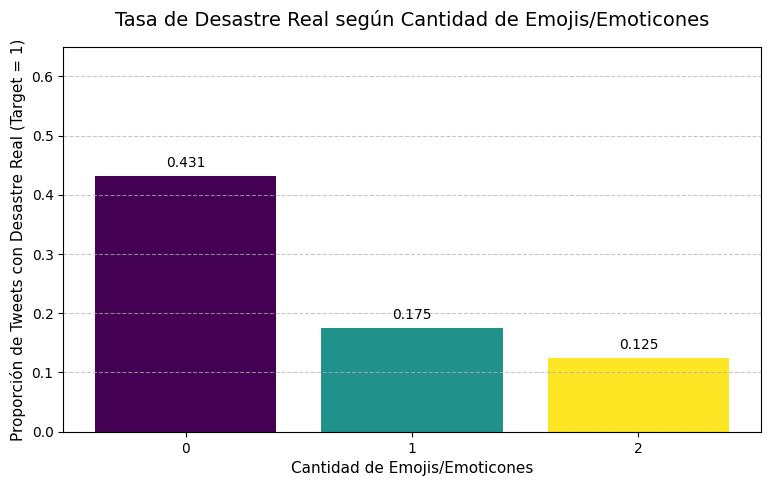

In [ ]:
# ==================================================
# GRÁFICO 1: Cantidad de Emojis vs Target
# ==================================================
emoji_stats = tweets_refactored.groupby('cantidad_emoji')['target'].mean().reset_index()
emoji_stats_filtered = emoji_stats[emoji_stats['cantidad_emoji'] <= 5]

plt.figure(figsize=(9, 5))
bars = plt.bar(
    emoji_stats_filtered['cantidad_emoji'].astype(str),
    emoji_stats_filtered['target'],
    color=plt.cm.viridis(np.linspace(0, 1, len(emoji_stats_filtered)))
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
             ha='center', va='bottom', fontsize=10)

plt.title('Tasa de Desastre Real según Cantidad de Emojis/Emoticones', fontsize=14, pad=15)
plt.ylabel('Proporción de Tweets con Desastre Real (Target = 1)', fontsize=11)
plt.xlabel('Cantidad de Emojis/Emoticones', fontsize=11)
plt.yticks(np.arange(0, 0.7, 0.1))
plt.ylim(0, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos notar que muy pocos tweets que contengan emojis sean desastres reales

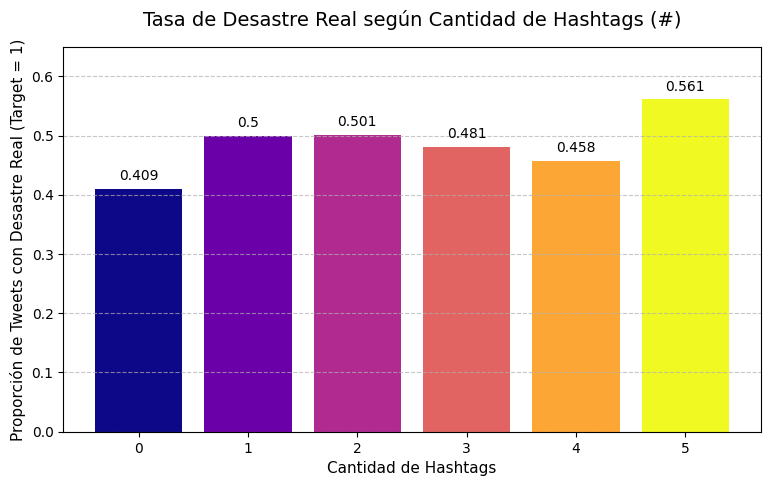

In [ ]:
# ==================================================
# GRÁFICO 2: Cantidad de Hashtags vs Target
# ==================================================
hashtags_stats = tweets_refactored.groupby('cantidad_hashtags')['target'].mean().reset_index()
hashtags_stats_filtered = hashtags_stats[hashtags_stats['cantidad_hashtags'] <= 5] # Se limita a 5 porque hay muy pocas muestras que tengan mas de 5

plt.figure(figsize=(9, 5))
bars = plt.bar(
    hashtags_stats_filtered['cantidad_hashtags'].astype(str),
    hashtags_stats_filtered['target'],
    color=plt.cm.plasma(np.linspace(0, 1, len(hashtags_stats_filtered)))
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
             ha='center', va='bottom', fontsize=10)

plt.title('Tasa de Desastre Real según Cantidad de Hashtags (#)', fontsize=14, pad=15)
plt.ylabel('Proporción de Tweets con Desastre Real (Target = 1)', fontsize=11)
plt.xlabel('Cantidad de Hashtags', fontsize=11)
plt.yticks(np.arange(0, 0.7, 0.1))
plt.ylim(0, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos notar que no hay una clara diferencia en el uso de #. Es cierto que varian pero no por tanto

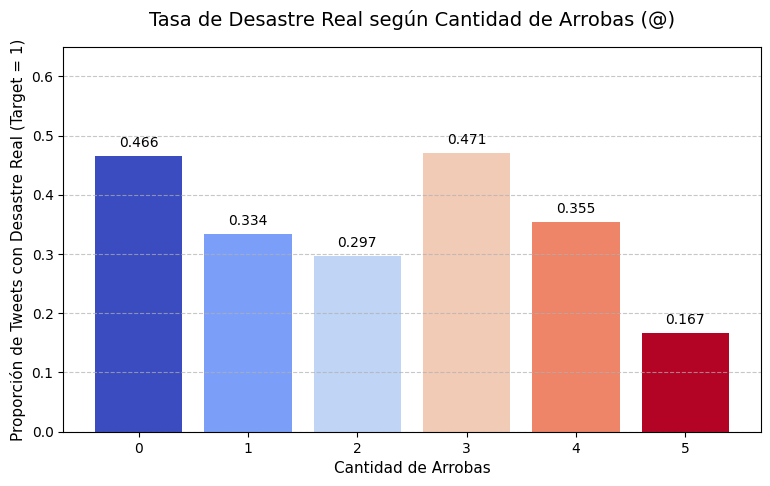

In [ ]:
# ==================================================
# GRÁFICO 3: Cantidad de Arrobas vs Target
# ==================================================
arrobas_stats = tweets_refactored.groupby('cantidad_arrobas')['target'].mean().reset_index()
arrobas_stats_filtered = arrobas_stats[arrobas_stats['cantidad_arrobas'] <= 5]

plt.figure(figsize=(9, 5))
bars = plt.bar(
    arrobas_stats_filtered['cantidad_arrobas'].astype(str),
    arrobas_stats_filtered['target'],
    color=plt.cm.coolwarm(np.linspace(0, 1, len(arrobas_stats_filtered)))
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
             ha='center', va='bottom', fontsize=10)

plt.title('Tasa de Desastre Real según Cantidad de Arrobas (@)', fontsize=14, pad=15)
plt.ylabel('Proporción de Tweets con Desastre Real (Target = 1)', fontsize=11)
plt.xlabel('Cantidad de Arrobas', fontsize=11)
plt.yticks(np.arange(0, 0.7, 0.1))
plt.ylim(0, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

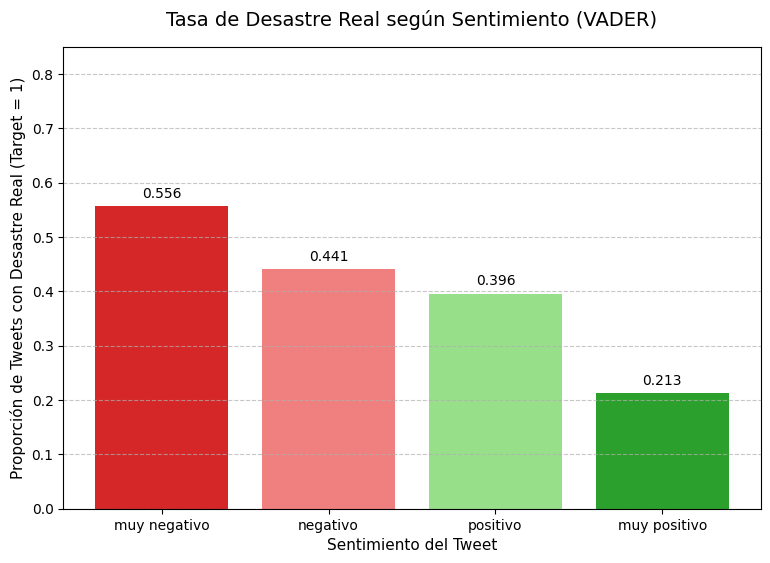

In [ ]:
# ==================================================
# GRÁFICO 4: Sentimiento (4 categorías) vs Target
# ==================================================

# Obtener la tasa de desastre real para cada categoría de sentimiento
sentimiento_stats = tweets_refactored.groupby('sentimiento')['target'].mean().reset_index()

# Definir el orden deseado para las categorías y colores
labels_ordenados = ['muy negativo', 'negativo', 'positivo', 'muy positivo']
colors = ['#d62728', '#f08080', '#98df8a', '#2ca02c']

# Reordenar el dataframe según los labels ordenados
sentimiento_stats['sentimiento'] = pd.Categorical(
    sentimiento_stats['sentimiento'], categories=labels_ordenados, ordered=True
)
sentimiento_stats = sentimiento_stats.sort_values('sentimiento')

plt.figure(figsize=(9, 6))
bars = plt.bar(
    sentimiento_stats['sentimiento'],
    sentimiento_stats['target'],
    color=colors
)

for bar in bars:
    yval = bar.get_height()
    if pd.isna(yval):
        yval = 0
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
             ha='center', va='bottom', fontsize=10)

plt.title('Tasa de Desastre Real según Sentimiento (VADER)', fontsize=14, pad=15)
plt.ylabel('Proporción de Tweets con Desastre Real (Target = 1)', fontsize=11)
plt.xlabel('Sentimiento del Tweet', fontsize=11)
plt.yticks(np.arange(0, 0.9, 0.1))
plt.ylim(0, 0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos notar que el sentimiento negativo y positivo no varian tanto pero si hay una gran diferencia entre el sentimiento muy negativo y muy positivo. Podemos notar que hay muy pocos desatres reales con un sentimiento muy positivo

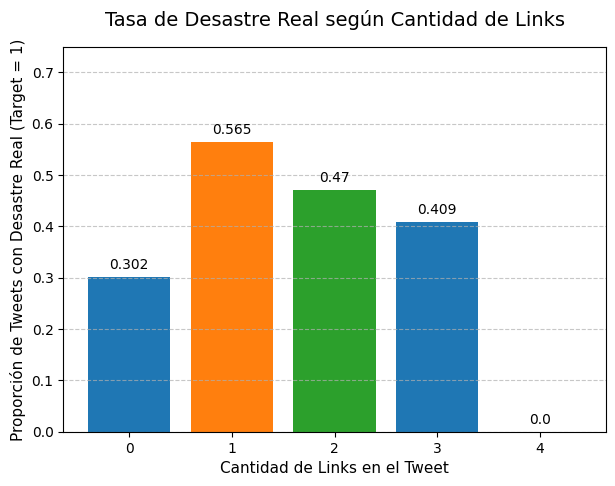

In [ ]:
# ==================================================
# GRÁFICO 5: Cantidad de Links vs Target
# ==================================================
links_stats = tweets_refactored.groupby('cantidad_links')['target'].mean().reset_index()

plt.figure(figsize=(7, 5))
bars = plt.bar(
    links_stats['cantidad_links'].astype(str),
    links_stats['target'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
             ha='center', va='bottom', fontsize=10)

plt.title('Tasa de Desastre Real según Cantidad de Links', fontsize=14, pad=15)
plt.ylabel('Proporción de Tweets con Desastre Real (Target = 1)', fontsize=11)
plt.xlabel('Cantidad de Links en el Tweet', fontsize=11)
plt.yticks(np.arange(0, 0.8, 0.1))
plt.ylim(0, 0.75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos ver como los que tienen link parece ser que tienen menos desastres reales que el resto. Esto a simple vista no parece tener sentido pero podrian estar linkeando a algo cierto y con relevancia

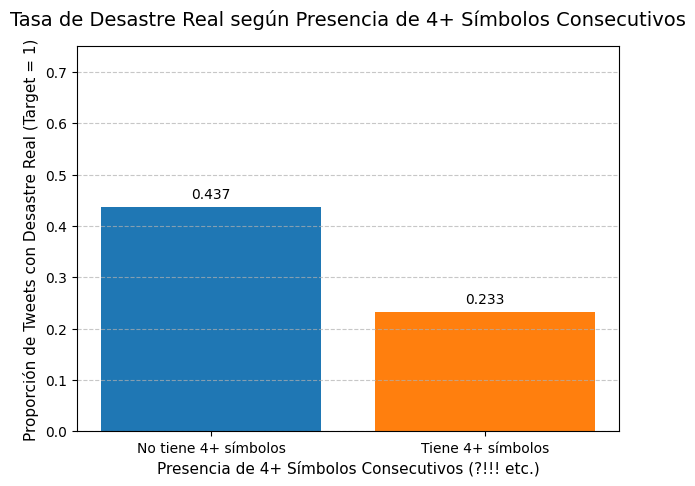

In [ ]:
# ==================================================
# GRÁFICO 6: Símbolos Consecutivos vs Target
# ==================================================
symbols_stats = tweets_refactored.groupby('tiene_4_simbolos_consecutivos')['target'].mean().reset_index()
symbols_stats['label'] = symbols_stats['tiene_4_simbolos_consecutivos'].replace(
    {0: 'No tiene 4+ símbolos', 1: 'Tiene 4+ símbolos'}
)

plt.figure(figsize=(7, 5))
bars = plt.bar(symbols_stats['label'], symbols_stats['target'], color=['#1f77b4', '#ff7f0e'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3),
             ha='center', va='bottom', fontsize=10)

plt.title('Tasa de Desastre Real según Presencia de 4+ Símbolos Consecutivos', fontsize=14, pad=15)
plt.ylabel('Proporción de Tweets con Desastre Real (Target = 1)', fontsize=11)
plt.xlabel('Presencia de 4+ Símbolos Consecutivos (?!!! etc.)', fontsize=11)
plt.yticks(np.arange(0, 0.8, 0.1))
plt.ylim(0, 0.75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Parece ser que los tweets con 4 o mas simbolos no suelen ser desastres reales

/tmp/ipython-input-67398874.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(
/tmp/ipython-input-67398874.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(


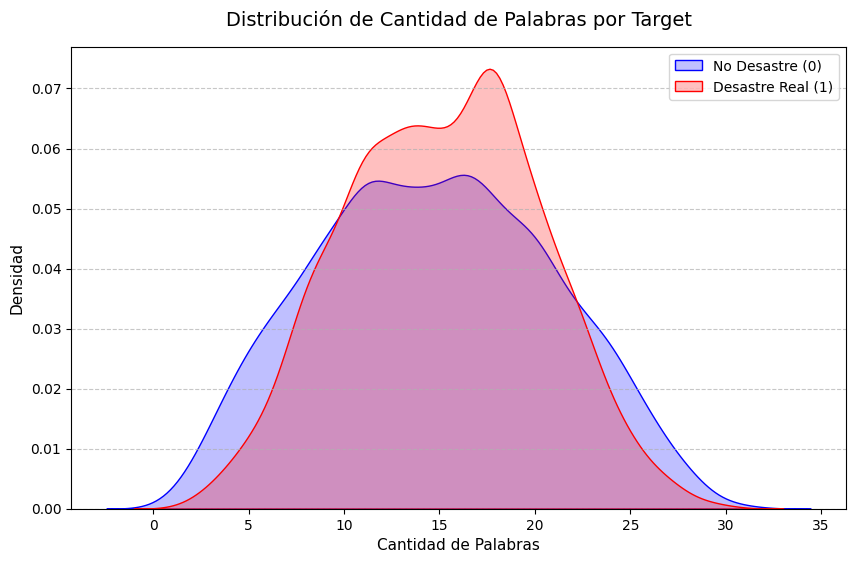

In [ ]:
# ==================================================
# GRÁFICO 7: Distribución de Cantidad de Palabras por Target
# ==================================================
plt.figure(figsize=(10, 6))
sbn.kdeplot(
    tweets_refactored[tweets_refactored['target']==0]['cantidad_palabras'],
    label='No Desastre (0)',
    shade=True,
    color='blue'
)
sbn.kdeplot(
    tweets_refactored[tweets_refactored['target']==1]['cantidad_palabras'],
    label='Desastre Real (1)',
    shade=True,
    color='red'
)
plt.title('Distribución de Cantidad de Palabras por Target', fontsize=14, pad=15)
plt.xlabel('Cantidad de Palabras', fontsize=11)
plt.ylabel('Densidad', fontsize=11)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos notar que no hay una gran diferencia en la densidad en base a la cantidad de palabras. Podemos ver como los tweets que no son desatres reales son un poco mas variados, es decir, hay mas variedad en la cantidad de palabras mientras que los desastres reales parecen concentrarse entre 10 y 20 palabras.

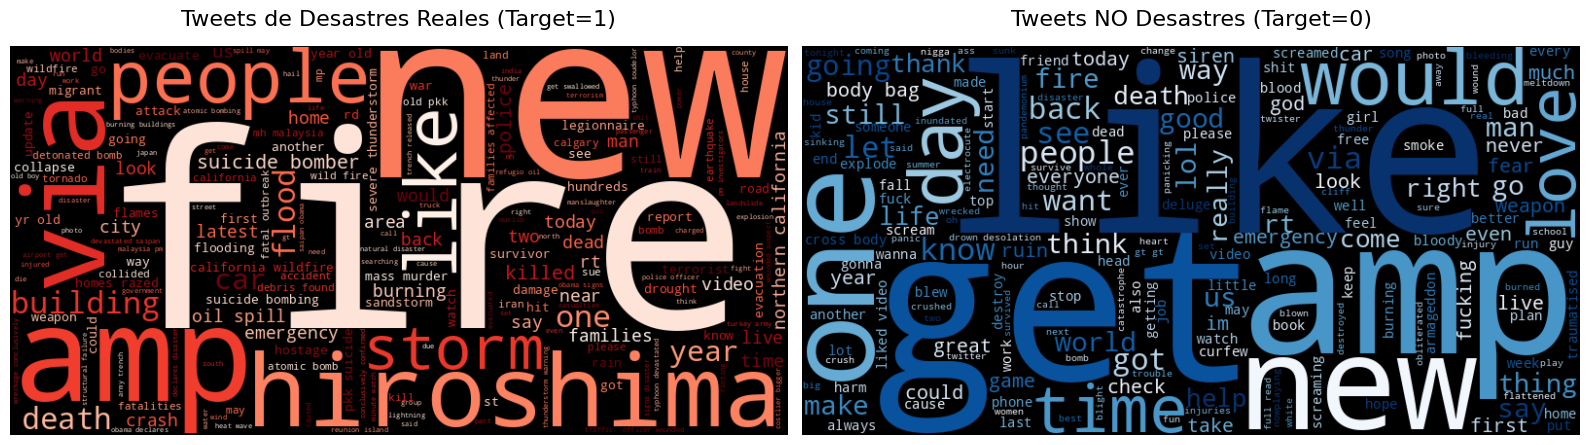

✅ WordClouds generados con texto limpio (sin URLs, menciones, hashtags, números)


In [ ]:
# ==================================================
# GRÁFICO 8: WordClouds - Desastres Reales vs No Desastres
# ==================================================

def limpiar_texto_wordcloud(texto):
    import re
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar URLs
    texto = re.sub(r'http\S+|www.\S+', '', texto)
    # Eliminar menciones (@username)
    texto = re.sub(r'@\w+', '', texto)
    # Eliminar hashtags (#), pero mantener la palabra
    texto = re.sub(r'#', '', texto)

    texto = re.sub(r'[^a-z\s]', ' ', texto)

    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Partimos el texto en palabras
    palabras = texto.split()
    # Nos quedamos solo con palabras de más de 1 letra
    palabras_filtradas = [palabra for palabra in palabras if len(palabra) > 1]
    # Las volvemos a unir
    texto = " ".join(palabras_filtradas)

    return texto

# Limpiar y preparar texto de desastres reales
tweets_desastre = tweets_refactored[tweets_refactored['target']==1]['text'].apply(limpiar_texto_wordcloud)
text_desastre = " ".join(tweets_desastre)

# Limpiar y preparar texto de NO desastres
tweets_no_desastre = tweets_refactored[tweets_refactored['target']==0]['text'].apply(limpiar_texto_wordcloud)
text_no_desastre = " ".join(tweets_no_desastre)

# Crear WordClouds con stopwords en inglés
stopwords_en = set(stopwords.words('english'))

wordcloud_desastre = WordCloud(
    background_color="black",
    width=800,
    height=400,
    stopwords=stopwords_en,
    max_words=200,
    colormap='Reds'
).generate(text_desastre)

wordcloud_no_desastre = WordCloud(
    background_color="black",
    width=800,
    height=400,
    stopwords=stopwords_en,
    max_words=200,
    colormap='Blues'
).generate(text_no_desastre)

# Mostrar los gráficos lado a lado
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(wordcloud_desastre, interpolation='bilinear')
ax[0].set_title('Tweets de Desastres Reales (Target=1)', fontsize=16, pad=15)
ax[0].axis("off")

ax[1].imshow(wordcloud_no_desastre, interpolation='bilinear')
ax[1].set_title('Tweets NO Desastres (Target=0)', fontsize=16, pad=15)
ax[1].axis("off")

plt.tight_layout()
plt.show()

print(f"✅ WordClouds generados con texto limpio (sin URLs, menciones, hashtags, números)")

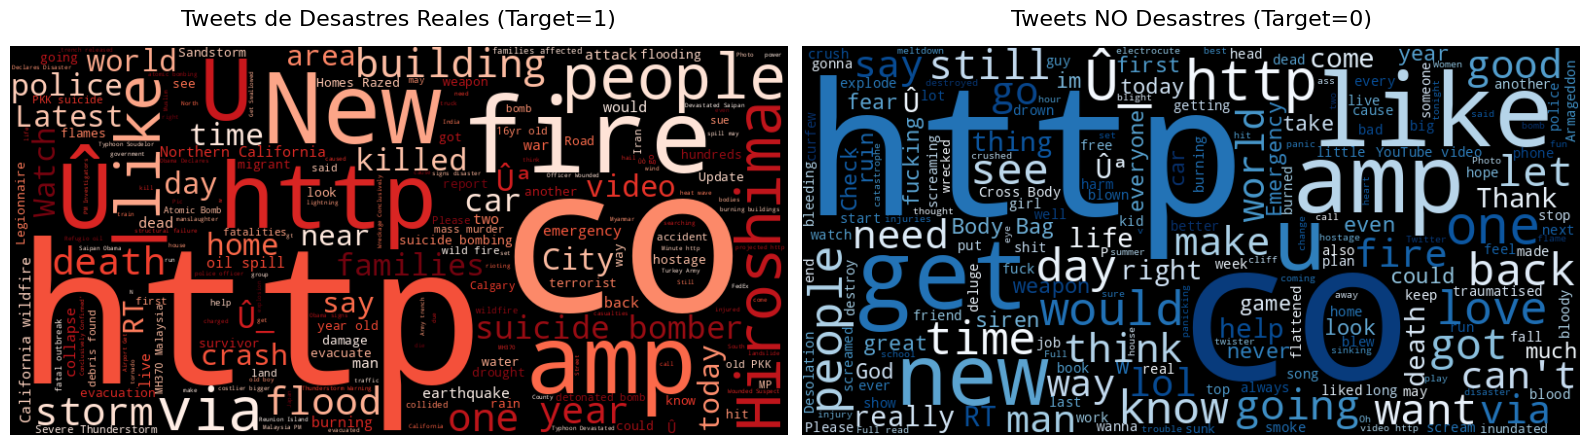

✅ WordClouds generados con texto original


In [ ]:
# ==================================================
# GRÁFICO 9: WordClouds - Desastres Reales vs No Desastres(sin limpieza)
# ==================================================

# Limpiar y preparar texto de desastres reales
tweets_desastre = tweets_refactored[tweets_refactored['target']==1]['text']
text_desastre = " ".join(tweets_desastre)

# Limpiar y preparar texto de NO desastres
tweets_no_desastre = tweets_refactored[tweets_refactored['target']==0]['text']
text_no_desastre = " ".join(tweets_no_desastre)

# Crear WordClouds con stopwords en inglés
stopwords_en = set(stopwords.words('english'))

wordcloud_desastre = WordCloud(
    background_color="black",
    width=800,
    height=400,
    stopwords=stopwords_en,
    max_words=200,
    colormap='Reds'
).generate(text_desastre)

wordcloud_no_desastre = WordCloud(
    background_color="black",
    width=800,
    height=400,
    stopwords=stopwords_en,
    max_words=200,
    colormap='Blues'
).generate(text_no_desastre)

# Mostrar los gráficos lado a lado
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(wordcloud_desastre, interpolation='bilinear')
ax[0].set_title('Tweets de Desastres Reales (Target=1)', fontsize=16, pad=15)
ax[0].axis("off")

ax[1].imshow(wordcloud_no_desastre, interpolation='bilinear')
ax[1].set_title('Tweets NO Desastres (Target=0)', fontsize=16, pad=15)
ax[1].axis("off")

plt.tight_layout()
plt.show()

print(f"✅ WordClouds generados con texto original")

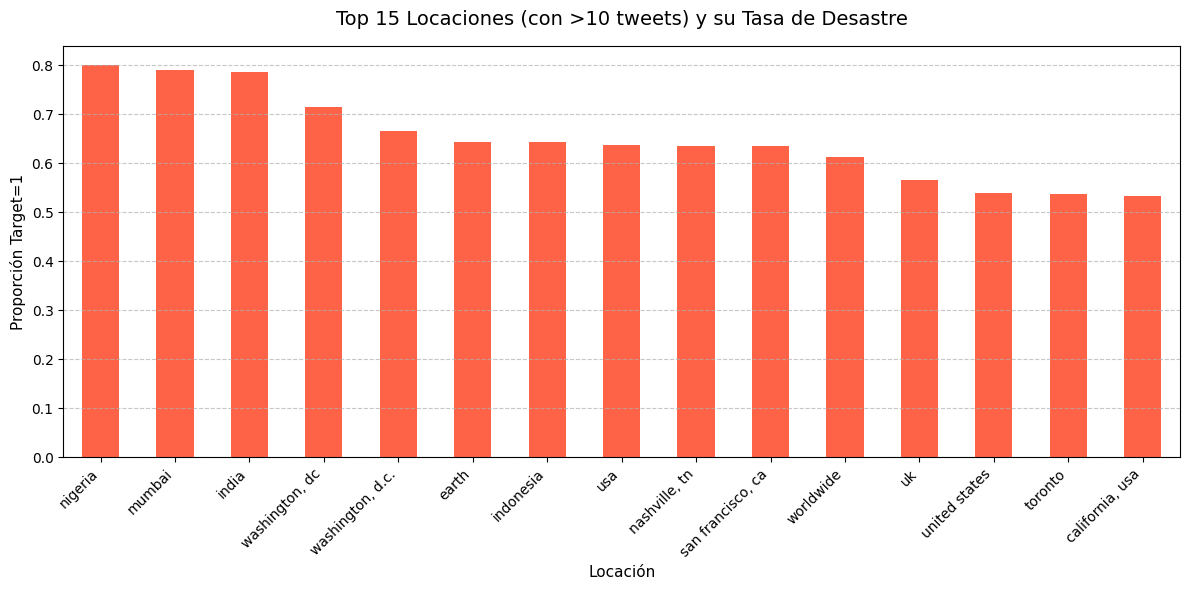

Total de locaciones únicas: 3175


In [ ]:
# ==================================================
# GRÁFICO 9: Top 15 Locaciones con Mayor Tasa de Desastre
# ==================================================
# Contar cuántos tweets tiene cada locación
loc_counts = tweets_refactored['location'].value_counts()

# Quedarse solo con locaciones que tienen más de 10 tweets
top_locs_names = loc_counts[loc_counts > 10].index

# Calcular la media de 'target' solo para esas locaciones
loc_stats = tweets_refactored[tweets_refactored['location'].isin(top_locs_names)].groupby('location')['target'].mean()

# Tomar las 15 con tasa de desastre más alta
top_15_locs = loc_stats.sort_values(ascending=False).head(15)

# Graficar
plt.figure(figsize=(12, 6))
top_15_locs.plot(kind='bar', color='tomato')
plt.title('Top 15 Locaciones (con >10 tweets) y su Tasa de Desastre', fontsize=14, pad=15)
plt.ylabel('Proporción Target=1', fontsize=11)
plt.xlabel('Locación', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Total de locaciones únicas: {tweets_refactored['location'].nunique()}")

Podemos ver como los tweets en nigeria, mumbai e india parecen ser en general incidentes reales